<a href="https://colab.research.google.com/github/henanliu/HIGH-RISE-CORE-LAYOUT/blob/main/CORE_LAYOUT_MULTI_LOBBIES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random as rnd
import seaborn as sns
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from google.colab import files
import time
from tqdm import tqdm
from scipy.spatial.distance import cdist

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#THEM CELLS, BRUH
class cell():
  def __init__(self,row,col,maxRow,maxCol):
    self.row = row
    self.col = col
    self.loc = [row,col]
    self.program = 0
    self.access = 0
    self.accessOut = 0
    self.maxRow = maxRow
    self.maxCol = maxCol
    self.corner = 0
    self.lstNeighbor = []
    self.detectBound()
    self.detectNeighbor()
    self.detectCorner()

  def assign(self,program,mapCore):
    self.program = program
    mapCore[self.row,self.col] = program
  
  def refresh(self):
    self.program = 0

  def detectBound(self):
    if self.row == 0 or self.row == self.maxRow -1 or self.col == 0 or self.col == self.maxCol - 1:
      self.access = 1
      self.accessOut = 1
    return self.access, self.accessOut
  
  def detectCorner(self):
    if self.row == 0 or self.row == self.maxRow - 1:
      if self.col == 0 or self.col == self.maxCol - 1:
        self.corner = 1
    return self.corner

  def detectAccess(self,lstCell):
    for i,coordinates in enumerate(self.lstNeighbor):
      iRow = coordinates[0]
      iCol = coordinates[1]
      cellNeighbor = lstCell[iRow][iCol]
      if cellNeighbor.program == 1:
        self.access = 1
        return self.access

  def detectNeighbor(self):
    self.lstRawNeighbor = [[self.row + 1, self.col],[self.row, self.col + 1],
                           [self.row - 1, self.col],[self.row, self.col - 1]]
    self.lstNeighbor = [coordinates for coordinates in self.lstRawNeighbor if 
                        (coordinates[0] in range(0,self.maxRow) and coordinates[1] in range(0,self.maxCol))]
    return self.lstNeighbor

#------------------------------------------------------------------------
#THE GAME
#rnd.seed(5)
#------------------------------------------------------------------------
#ELEVATOR LOBBY
def createElevatorLobby (elevLobbyAmount,straight,lstCell,mapCore,iProgram):
  cElevLobby = []
  lstAvailableStart = []
  for i,row in enumerate(lstCell):
    for j,block in enumerate(row):
      if block.accessOut == 1 and block.corner == 0 and block.program == 0:
        lstAvailableStart.append([i,j])
  iStart = rnd.randint(0,len(lstAvailableStart)-1)
  iRow = lstAvailableStart[iStart][0]
  iCol = lstAvailableStart[iStart][1]
  elevLobbyStart = lstCell[iRow][iCol]
  elevLobbyStart.assign(iProgram,mapCore)
  cElevLobby.append([iRow,iCol])

  if straight == 1:
    if elevLobbyStart.row == 0:
      coX,coY = 1,0
    elif elevLobbyStart.row == elevLobbyStart.maxRow-1:
      coX,coY = -1,0
    elif elevLobbyStart.col == 0:
      coX,coY = 0,1
    elif elevLobbyStart.col == elevLobbyStart.maxCol-1:
      coX,coY = 0,-1
      
    cellLast = elevLobbyStart
    for i in range(elevLobbyAmount-1):
      if lstCell[cellLast.row + 1*coX][cellLast.col + 1*coY].program == 0:
        cellNext = lstCell[cellLast.row + 1*coX][cellLast.col + 1*coY]
        cellNext.assign(iProgram, mapCore)
        cElevLobby.append([cellLast.row + 1*coX,cellLast.col + 1*coY])
        cellLast = cellNext
      elif not muted:
        print ('Not Enough room for ' + legendProgram[iProgram][1])
        break

  else:
    cellLast = elevLobbyStart
    for i in range(elevLobbyAmount-1):
      lstRawNeighbor = cellLast.lstNeighbor
      lstNeighbor = [iNeighbor for iNeighbor in lstRawNeighbor 
                    if lstCell[iNeighbor[0]][iNeighbor[1]].program == 0]
      if len(lstNeighbor) > 0:
        iNext = rnd.randint(0,len(lstNeighbor)-1)
        cNext = lstNeighbor[iNext]
        cellNext = lstCell[cNext[0]][cNext[1]]
        cellNext.assign(iProgram,mapCore)
        cElevLobby.append(cNext)
        cellLast = cellNext
      elif not muted:
        print ('Not Enough room for ' + legendProgram[iProgram][1])
        break
  return cElevLobby

def cluster(lstElev):
  rnd.shuffle(lstElev)
  X = lstElev
  Z = linkage(X, method='single', metric='euclidean')
  maxDis = 1.1
  iCluster = fcluster(Z, maxDis, criterion='distance')
  iCluster = iCluster.tolist()
  newlist = [(x + [iCluster[i]]) for i,x in enumerate(lstElev)]
  values = set(map(lambda x:x[2], newlist))
  newlist2 = [[y[:2] for y in newlist if y[2]==x] for x in values]
  w = ([-1,1][rnd.randrange(2)])
  newlist3 = [sorted(sublist, key=lambda x: (w*x[0], w*x[1])) for sublist in newlist2]
  return newlist3

def assignElev(lstCell,lstCluster,cElev,mapCore,elevAmount,iProgram):
  maxInCluster = 3
  counter = 0
  for j,cluster in enumerate(lstCluster):
    innerCounter = 0
    if len(cluster) > maxInCluster:
      skip = len(cluster) - maxInCluster
      skip = rnd.randint(0,skip)
      cluster = cluster[skip:]
    for k, coordinates in enumerate(cluster):
      if counter < elevAmount:
        iRow = coordinates[0]
        iCol = coordinates[1]
        lstCell[iRow][iCol].assign(iProgram,mapCore)
        cElev.append(coordinates)
        counter += 1
        innerCounter += 1
        if innerCounter >= 3:
          break
      else:
        return

def createGuestElevator(lstCell,mapCore,iProgram,cElevLobby):
  hoistwayAmount = 2 # REFER TO IBC SECTION 3002
  elevAmount = 5
  cElev = []
  lstRawElev = []
  for i,row in enumerate(lstCell):
    for j,block in enumerate(row):
      if block.program == 1:
        stuff = block.lstNeighbor
        lstRawElev.extend(stuff)
  lstElev = [list(i) for i in set(map(tuple, lstRawElev))]
  lstElev = [c for c in lstElev if c not in cElevLobby]
  lstCluster = cluster(lstElev)
  lstCluster.sort(key = len,reverse=True)
  assignElev(lstCell,lstCluster,cElev,mapCore,elevAmount,iProgram)
  if len(cElev)<elevAmount and not muted:
    print ('Not Enough room for ' + legendProgram[iProgram][1])
  return cElev

def createGuestElevByClosest(elevAmount,lstCell,mapCore,iProgram,cElevLobby):
  cList = []
  lstRawElev = []
  for coordinate in cElevLobby:
    stuff = lstCell[coordinate[0]][coordinate[1]].lstNeighbor
    lstRawElev.extend(stuff)
  lstElev = [list(i) for i in set(map(tuple, lstRawElev))]
  cAvail = [c for c in lstElev if c not in cElevLobby]
  cAvail = [c for c in cAvail if lstCell[c[0]][c[1]].program == 0]
  if len(cAvail) >= elevAmount:
    cBase = rnd.choice(cElevLobby)
    aBase = np.asarray(cBase).reshape(1,2)
    aAvail = np.asarray(cAvail)
    aDis = cdist(aBase,aAvail)
    aOrder = np.argsort(aDis)
    cAvail = aAvail[aOrder].tolist()[0]
    for i in range(elevAmount):
      coordinates = cAvail[i]
      iRow = coordinates[0]
      iCol = coordinates[1]
      lstCell[iRow][iCol].assign(iProgram,mapCore)
      cList.append(coordinates)
  elif not muted:
    print ('Not Enough room for ' + legendProgram[iProgram][1])
  return cList

def findAccess(lstCell):
  lstAccess = [] 
  for row in lstCell:
    for stuff in row:
      stuff.detectAccess(lstCell)
      if stuff.access == 1 and stuff.program == 0:
        lstAccess.append(stuff.loc)
  return lstAccess

def createOneFromOpen(lstCell,mapCore,iProgram):
  cList = []
  lstAccess = findAccess(lstCell)
  rnd.shuffle(lstAccess)
  for i, coordinates in enumerate(lstAccess):
    iRow = coordinates[0]
    iCol = coordinates[1]
    lstN = lstCell[iRow][iCol].lstNeighbor
    if lstCell[iRow][iCol].program == 0:
      lstCell[iRow][iCol].assign(iProgram,mapCore)
      cList.append(coordinates)
      return cList
  if len(cList)<1 and not muted:
    print ('Not Enough room for ' + legendProgram[iProgram][1])

def createTwoFromOpen(lstCell,mapCore,iProgram):
  cList = []
  lstAccess = findAccess(lstCell)
  rnd.shuffle(lstAccess)
  for i, coordinates in enumerate(lstAccess):
    iRow = coordinates[0]
    iCol = coordinates[1]
    lstN = lstCell[iRow][iCol].lstNeighbor
    lstAvl = [c for c in lstN if lstCell[c[0]][c[1]].program == 0]
    if len(lstAvl) > 0:
      lstCell[iRow][iCol].assign(iProgram,mapCore)
      cList.append(coordinates)
      rnd.shuffle(lstAvl)
      iRow_b = lstAvl[0][0]
      iCol_b = lstAvl[0][1]
      lstCell[iRow_b][iCol_b].assign(iProgram,mapCore)
      cList.append(lstAvl[0])
      break
  if len(cList) < 2 and not muted:
    print ('Not Enough room for ' + legendProgram[iProgram][1])
  return cList

def createOneFromMultiple(lstCell,mapCore,iProgram,lstBase):
  cList = []
  rnd.shuffle(lstBase)
  for i, coordinates in enumerate(lstBase):
    iRow = coordinates[0]
    iCol = coordinates[1]
    lstN = lstCell[iRow][iCol].lstNeighbor
    lstAvl = [c for c in lstN if lstCell[c[0]][c[1]].program == 0]
    if len(lstAvl) > 0:
      rnd.shuffle(lstAvl)
      iRow_b = lstAvl[0][0]
      iCol_b = lstAvl[0][1]
      lstCell[iRow_b][iCol_b].assign(iProgram,mapCore)
      cList.append(lstAvl[0])
      return cList
  if len(cList)<1 and not muted:
    print ('Not Enough room for ' + legendProgram[iProgram][1])

def createTwoFromMultiple(lstCell,mapCore,iProgram,lstBase):
  cList = []
  rnd.shuffle(lstBase)
  signal = 0
  for i, coordinates in enumerate(lstBase):
    iRow = coordinates[0]
    iCol = coordinates[1]
    lstN = lstCell[iRow][iCol].lstNeighbor
    lstAvl = [c for c in lstN if lstCell[c[0]][c[1]].program == 0]
    if len(lstAvl) > 0:
      rnd.shuffle(lstAvl)
      for j, coordinates_b in enumerate(lstAvl):
        iRow_b = coordinates_b[0]
        iCol_b = coordinates_b[1]
        lstN_b = lstCell[iRow_b][iCol_b].lstNeighbor
        lstAvl_b = [c_b for c_b in lstN_b if lstCell[c_b[0]][c_b[1]].program == 0 and c_b != coordinates ]
        if len(lstAvl_b)>0:
          lstCell[iRow_b][iCol_b].assign(iProgram,mapCore)
          cList.append(coordinates_b)
          rnd.shuffle(lstAvl_b)
          iRow_c = lstAvl_b[0][0]
          iCol_c = lstAvl_b[0][1]
          lstCell[iRow_c][iCol_c].assign(iProgram,mapCore)
          cList.append(lstAvl_b[0])
          signal = 1
          return cList
  if len(cList)<2 and not muted:
    print ('Not Enough room for ' + legendProgram[iProgram][1])

def createOne(lstCell,mapCore,iProgram):
  cList = []
  lstOpen = []
  for row in lstCell:
    for stuff in row:
      if stuff.program == 0:
        lstOpen.append(stuff.loc)
  rnd.shuffle(lstOpen)
  coordinates = lstOpen[0]
  iRow = coordinates[0]
  iCol = coordinates[1]
  lstCell[iRow][iCol].assign(iProgram,mapCore)
  cList.append(coordinates)
  return cList
  if len(cList)<1 and not muted:
    print ('Not Enough room for ' + legendProgram[iProgram][1])

def rateCore(scoreInitial,mapCore):
  score = scoreInitial - np.count_nonzero(mapCore==0)
  return score

def checkLobbyStraight(cElevLobby):
  lobbyStraight = False
  if cElevLobby[0][1] == cElevLobby[1][1] == cElevLobby[2][1] == cElevLobby[3][1]:
    lobbyStraight = True
  return lobbyStraight

#------------------------------------------------------------------------
#LOBBY
legendProgram = [[0,' '],[1,'L_1'],[2,'GE_1'],[3,'L_2'],[4,'GE_2'],[5,'L_3'],[6,'GE_3'],
                 [7,'V_1'],[8,'FE'],[9,'S_1'],[10,'V_2'],[11,'S_2'],[12,'ADA'],[13,'MEP'],[14,'SHAFT']]
maxCol = 7
maxRow = 6
#lstCell = [[cell(i,j,maxRow,maxCol) for j in range(maxCol)] for i in range(maxRow)]
benchMark = 10
muted = True # Set to False only when knowing which program has not enough room is needed
def main():
  #Initiate
  lstCell = [[cell(i,j,maxRow,maxCol) for j in range(maxCol)] for i in range(maxRow)]
  mapCore = np.zeros((maxRow,maxCol)) #Creating the game map
  #for rating the product
  cElevLobby = createElevatorLobby(6,0,lstCell,mapCore,1)
  #GUEST ELEVATOR
  #cElev = createGuestElevator(lstCell,mapCore,2, cElevLobby)
  cElev = createGuestElevByClosest(6,lstCell,mapCore,2, cElevLobby)
  #CREATE SECOND ELEVATOR LOBBY AND ELEVATOR
  cElevLobby2 = createElevatorLobby(3,0,lstCell,mapCore,3)
  cElev2 = createGuestElevByClosest(5,lstCell,mapCore,4, cElevLobby2)
  #CREATE SECOND ELEVATOR LOBBY AND ELEVATOR
  cElevLobby3 = createElevatorLobby(3,0,lstCell,mapCore,5)
  cElev3 = createGuestElevByClosest(4,lstCell,mapCore,6, cElevLobby3)
  #VESTIBULE A
  cVest_A = createTwoFromOpen(lstCell,mapCore,7)
  #STAIR A
  cStair_A = createTwoFromMultiple(lstCell,mapCore,9,cVest_A)
  #FREIGHT ELEVATOR
  cFElev_A = createOneFromMultiple(lstCell,mapCore,8,cVest_A)
  cFElev_B = createOneFromMultiple(lstCell,mapCore,8,cVest_A)
  #VESTIBULE B
  cVest_B = createOneFromOpen(lstCell,mapCore,10)
  #STAIR B
  cStair_B = createTwoFromMultiple(lstCell,mapCore,11,cVest_B)
  #ADA RESTROOM
  cADA = createOneFromOpen(lstCell,mapCore,12)
  #PLUMBING
  cPLM = createOneFromOpen(lstCell,mapCore,13)
  #ELECTRIC HIGH
  cE_A = createOneFromOpen(lstCell,mapCore,13)
  #ELECTRIC LOW
  cE_B = createOneFromOpen(lstCell,mapCore,13)
  #SHAFT
  shaft_A = createOne(lstCell,mapCore,14)
  shaft_B = createOne(lstCell,mapCore,14)
  #Rating
  scoreCore = rateCore(benchMark,mapCore)
  lobbyStraight = checkLobbyStraight(cElevLobby)
  return scoreCore, lstCell, mapCore, lobbyStraight


6


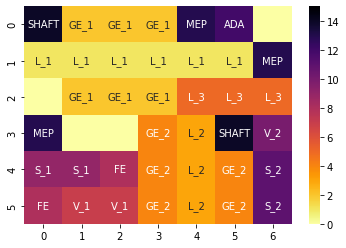

In [ ]:
#ONE TIME TESTING AND RENDERING
scoreCore,lstCell,mapCore,lobbyStraight = main()
print (scoreCore)
lstText = []
for row in lstCell:
  for stuff in row:
    for t in legendProgram:
      if stuff.program == t[0]:
        lstText.append(t[1])
        break
mapProgram = np.array(lstText)
mapProgram2 = np.reshape(mapProgram,(maxRow,maxCol))
plt.clf()
ax = sns.heatmap(mapCore, cmap="inferno_r", annot=mapProgram2, annot_kws={'fontsize': 10},fmt='',vmin=0, vmax=len(legendProgram))

ONE SUCCESS AFTER 39 ATTEMPTS


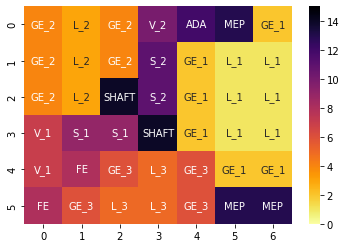

In [ ]:
#LOOP UNTIL ONE INCIDENCE OF SUCCESS
for i in range(100):
  scoreCore,lstCell,mapCore,lobbyStraight = main()
  if scoreCore >= benchMark:
    print ('ONE SUCCESS AFTER ' + str(i) + ' ATTEMPTS')
    lstText = []
    for row in lstCell:
      for stuff in row:
        for t in legendProgram:
          if stuff.program == t[0]:
            lstText.append(t[1])
            break
    mapProgram = np.array(lstText)
    mapProgram2 = np.reshape(mapProgram,(maxRow,maxCol))
    plt.clf()
    ax = sns.heatmap(mapCore, cmap="inferno_r", annot=mapProgram2, annot_kws={'fontsize': 10},fmt='',vmin=0, vmax=len(legendProgram))
    break

 57%|█████▋    | 11434/20000 [00:48<00:36, 237.20it/s]


TypeError: ignored

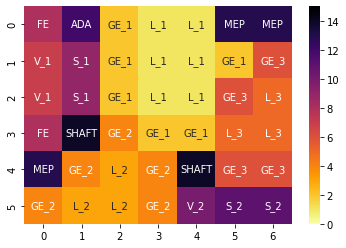

In [ ]:
counter = 0
repetition = 20000
for i in tqdm(range(repetition)):
  scoreCore, lstCell, mapCore, lobbyStraight = main()
  if scoreCore == benchMark:
    counter += 1
    lstText = []
    for row in lstCell:
      for stuff in row:
        for t in legendProgram:
          if stuff.program == t[0]:
            lstText.append(t[1])
            break
    mapProgram = np.array(lstText)
    mapProgram2 = np.reshape(mapProgram,(maxRow,maxCol))
    plt.clf()
    ax = sns.heatmap(mapCore, cmap="inferno_r", annot=mapProgram2, annot_kws={'fontsize': 10},fmt='',vmin=0, vmax=len(legendProgram))
    timestr = time.strftime("%Y%m%d-%H%M%S")
    dir = '/content/gdrive/My Drive/GENSLER/SMART_TOOLKIT/01_CORE_LAYOUT/PLOT/20230106/'
    #if lobbyStraight:
      #print ('Got one straight @ ' + timestr + str(counter))
      #fig = ax.figure.savefig(dir + 'lobbyStraight/' + timestr + str(counter) + '.png') 
    #else:
      #fig = ax.figure.savefig(dir + timestr + str(counter) + '.png') 
    fig = ax.figure.savefig(dir + timestr + str(counter) + '.png')
  if i == repetition-1:
    print (str(counter) + 'layouts have been saved')

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
fig = ax.figure.savefig('test' + timestr + '.png') 
files.download('test' + timestr + '.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>